In [2]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm


# Set seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Arrythmia Dataset
- Number of samples: 109446
- Number of categories: 5
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrythmia Dataset

In [2]:
# # Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# device = 'cpu'

cuda


In [4]:
input_size = 187
cnn_output_size = 64
hidden_size = 128
num_classes = 5

patience = 3
no_epochs = 50
batch_size = 128
lr = 0.0001

n_fft = 64         # Size of FFT window
hop_length = 1     # Number of samples between successive frames
win_length = 64    # Window size
window = torch.hann_window(win_length).to(device)
center = True      # Whether to pad the signal

## Data exploration

In [31]:
# train_df = pd.read_csv('/content/drive/MyDrive/nn_group/mitbih_train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/nn_group/mitbih_test.csv')

# raw_train_df = pd.read_csv('mitbih_train.csv')
raw_test_df = pd.read_csv('mitbih_test.csv')
df_test = raw_test_df


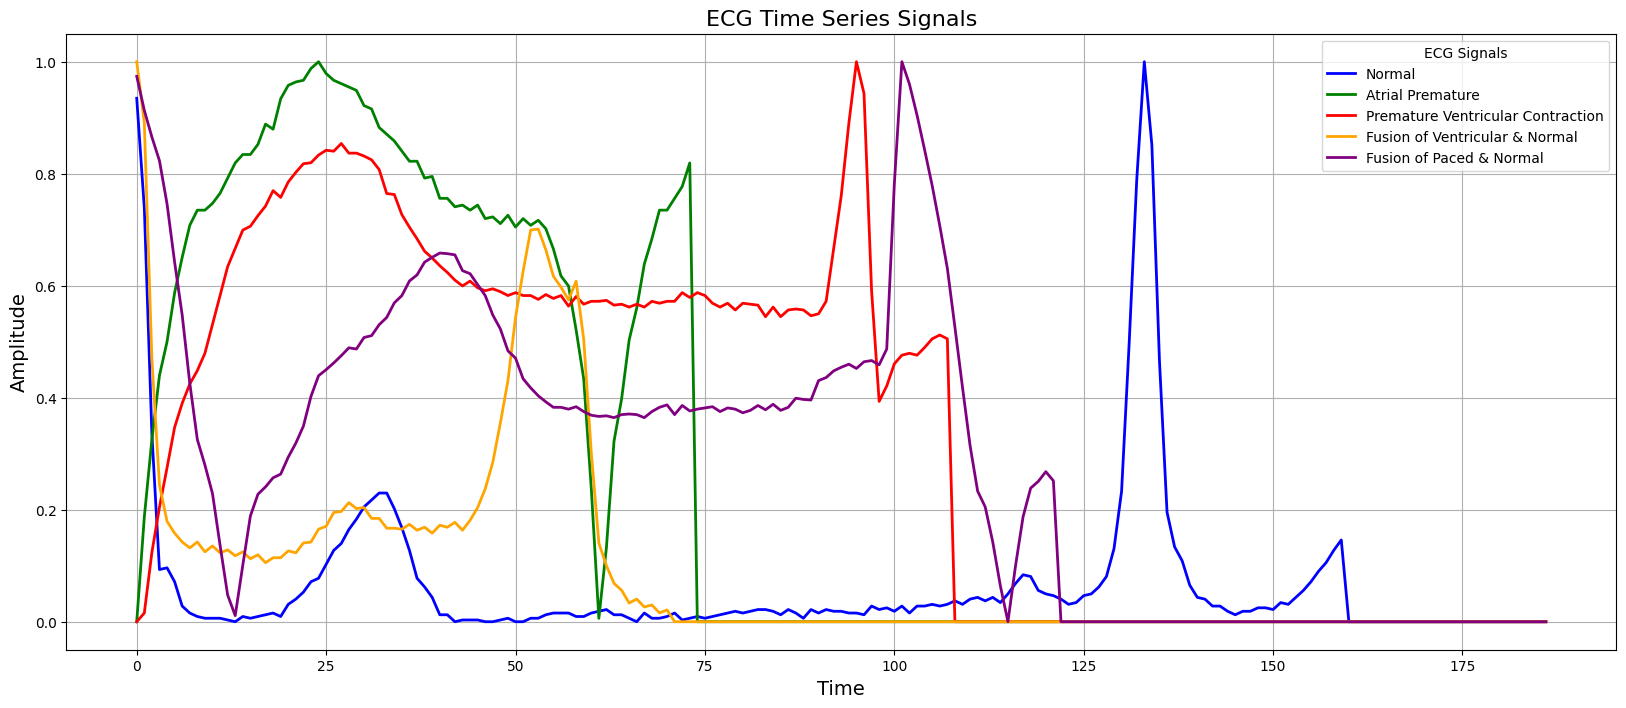

In [37]:
signals = [18116, 18672, 20120, 20282, 21890]
colors = ['blue', 'green', 'red', 'orange', 'purple']
signals_cat = ['Normal', 'Atrial Premature', 'Premature Ventricular Contraction', 'Fusion of Ventricular & Normal', 'Fusion of Paced & Normal']
x_axis = [i for i in range(187)]

# Loop through each signal and plot
plt.figure(figsize=(20, 8))
for i, signal in enumerate(signals):
    plt.plot(
        x_axis,
        df_test.iloc[signals[i], :-1].astype(float).values,
        color=colors[i % len(colors)],
        linestyle='-',
        linewidth=2,
        label=f'{signals_cat[i]}'
    )

plt.title('ECG Time Series Signals', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(title='ECG Signals')
plt.grid(True)  # Adding a grid for better readability
plt.show()

0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64
0.0


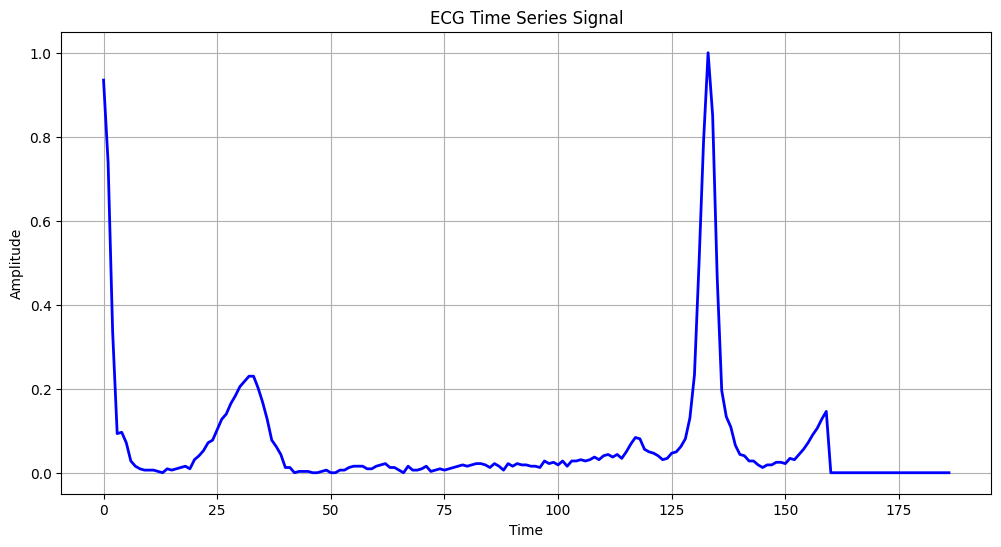

In [21]:
df_test = raw_test_df

print(df_test.iloc[:, -1].value_counts())

idx = 18116
x_axis = [i for i in range(187)]
y_axis = df_test.iloc[idx, :-1].astype(float).values
print(df_test.iloc[idx, -1])
graph = pd.Series(y_axis, index=x_axis)
graph.plot(
    kind='line',
    figsize=(12, 6),           # Setting the figure size
    color='blue',              # Line color
    linewidth=2,               # Line width
    linestyle='-',             # Line style
    title='ECG Time Series Signal',
    xlabel='Time',
    ylabel='Amplitude'
)

plt.grid(True)  # Adding a grid for better readability
plt.show()

1.0


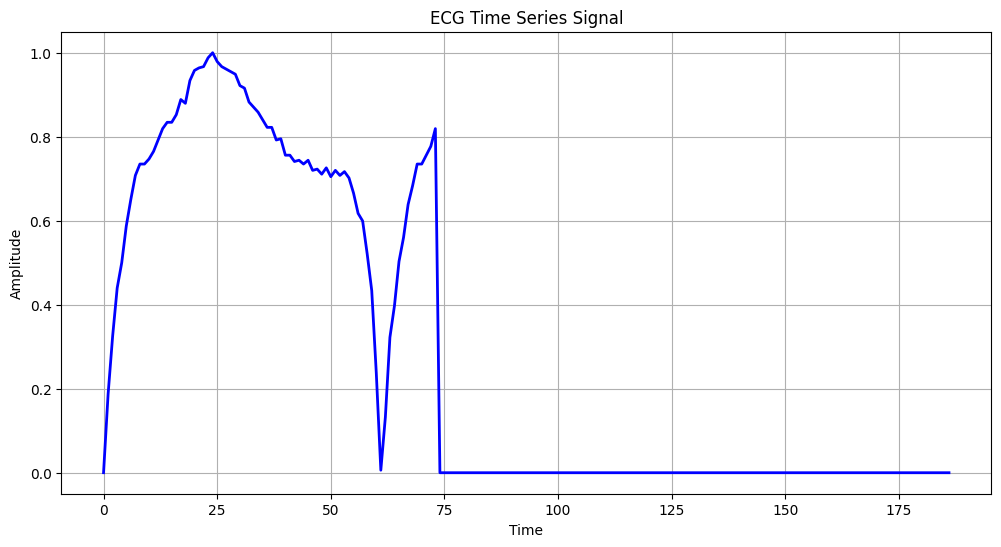

In [29]:
idx = 18672
print(df_test.iloc[idx, -1])
x_axis = [i for i in range(187)]
y_axis = df_test.iloc[idx, :-1].astype(float).values
graph = pd.Series(y_axis, index=x_axis)
graph.plot(
    kind='line',
    figsize=(12, 6),           # Setting the figure size
    color='blue',              # Line color
    linewidth=2,               # Line width
    linestyle='-',             # Line style
    title='ECG Time Series Signal',
    xlabel='Time',
    ylabel='Amplitude'
)

plt.grid(True)  # Adding a grid for better readability
plt.show()

2.0


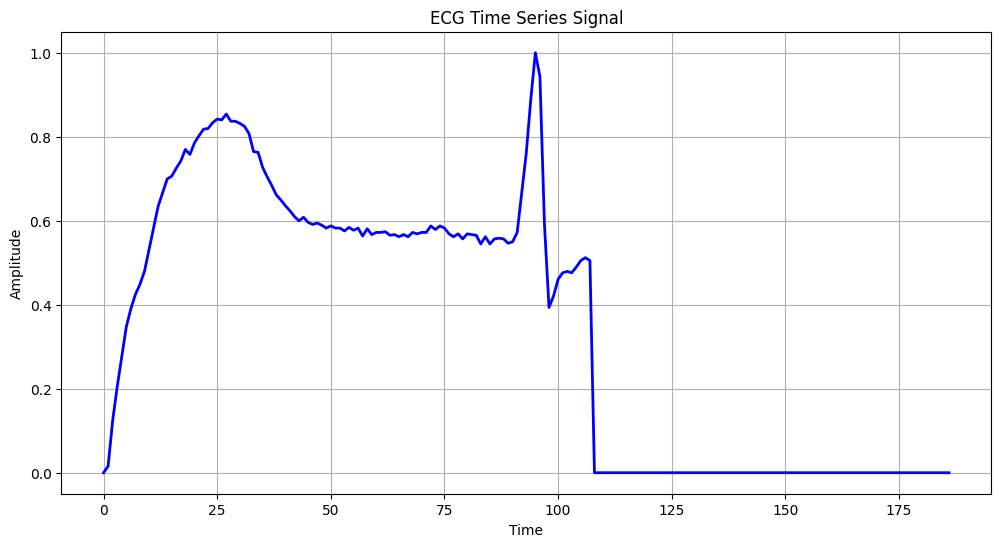

In [28]:
idx = 20120
print(df_test.iloc[idx, -1])
x_axis = [i for i in range(187)]
y_axis = df_test.iloc[idx, :-1].astype(float).values
graph = pd.Series(y_axis, index=x_axis)
graph.plot(
    kind='line',
    figsize=(12, 6),           # Setting the figure size
    color='blue',              # Line color
    linewidth=2,               # Line width
    linestyle='-',             # Line style
    title='ECG Time Series Signal',
    xlabel='Time',
    ylabel='Amplitude'
)

plt.grid(True)  # Adding a grid for better readability
plt.show()

3.0


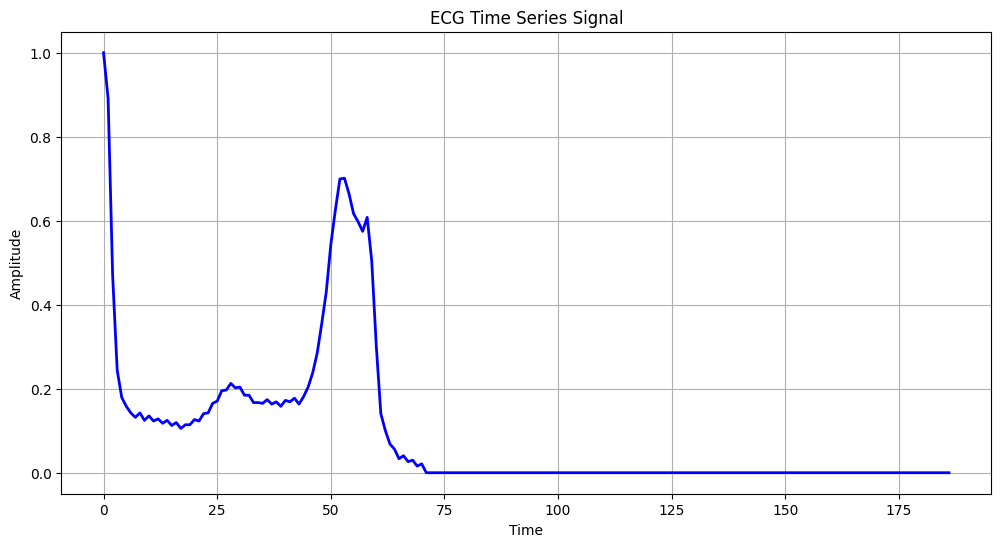

In [27]:
idx = 20282
print(df_test.iloc[idx, -1])
x_axis = [i for i in range(187)]
y_axis = df_test.iloc[idx, :-1].astype(float).values
graph = pd.Series(y_axis, index=x_axis)
graph.plot(
    kind='line',
    figsize=(12, 6),           # Setting the figure size
    color='blue',              # Line color
    linewidth=2,               # Line width
    linestyle='-',             # Line style
    title='ECG Time Series Signal',
    xlabel='Time',
    ylabel='Amplitude'
)

plt.grid(True)  # Adding a grid for better readability
plt.show()

4.0


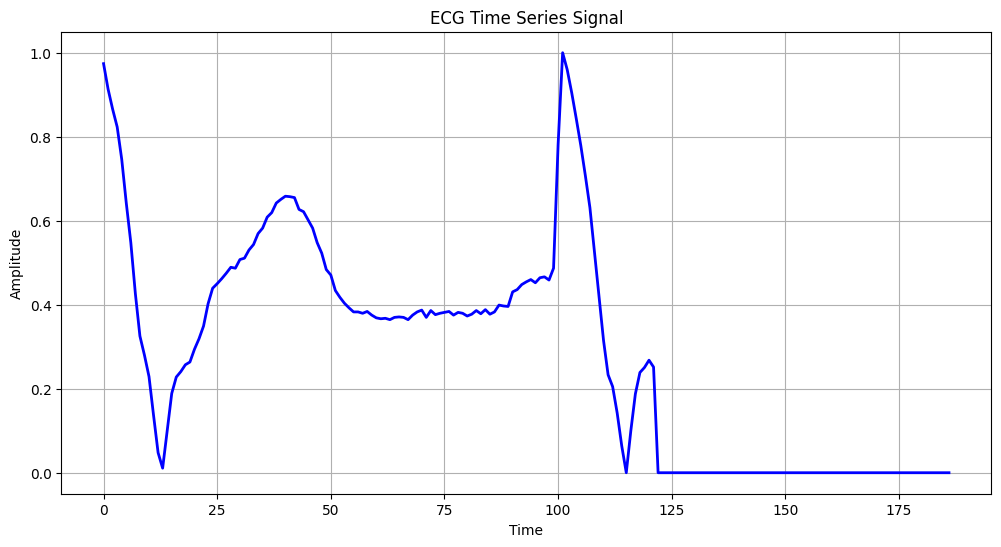

In [26]:
idx = 21890
print(df_test.iloc[idx, -1])
x_axis = [i for i in range(187)]
y_axis = df_test.iloc[idx, :-1].astype(float).values
graph = pd.Series(y_axis, index=x_axis)
graph.plot(
    kind='line',
    figsize=(12, 6),           # Setting the figure size
    color='blue',              # Line color
    linewidth=2,               # Line width
    linestyle='-',             # Line style
    title='ECG Time Series Signal',
    xlabel='Time',
    ylabel='Amplitude'
)

plt.grid(True)  # Adding a grid for better readability
plt.show()

In [10]:
# print(f"Shape of train data: {train_df.shape}")
# print(f"Shape of test data: {test_df.shape}")
# print(f"NaN values in train data: {train_df.isna().sum().sum()}")
# print(f"NaN values in test data: {test_df.isna().sum().sum()}")

# # Last column stores the labels
# print(train_df.iloc[:, -1].unique())
# print(test_df.iloc[:, -1].unique())

# train_df.iloc[:, -1].value_counts()
# test_df.iloc[:, -1].value_counts()

From the counts of the classes, we can observe that the dataset is imbalanced, as class = 0 makes up a large proportion of the training (82.77%) and test data (82.76%). However, we will go ahead with training and evaluating for now and observe the results.

## Data visualisation for results

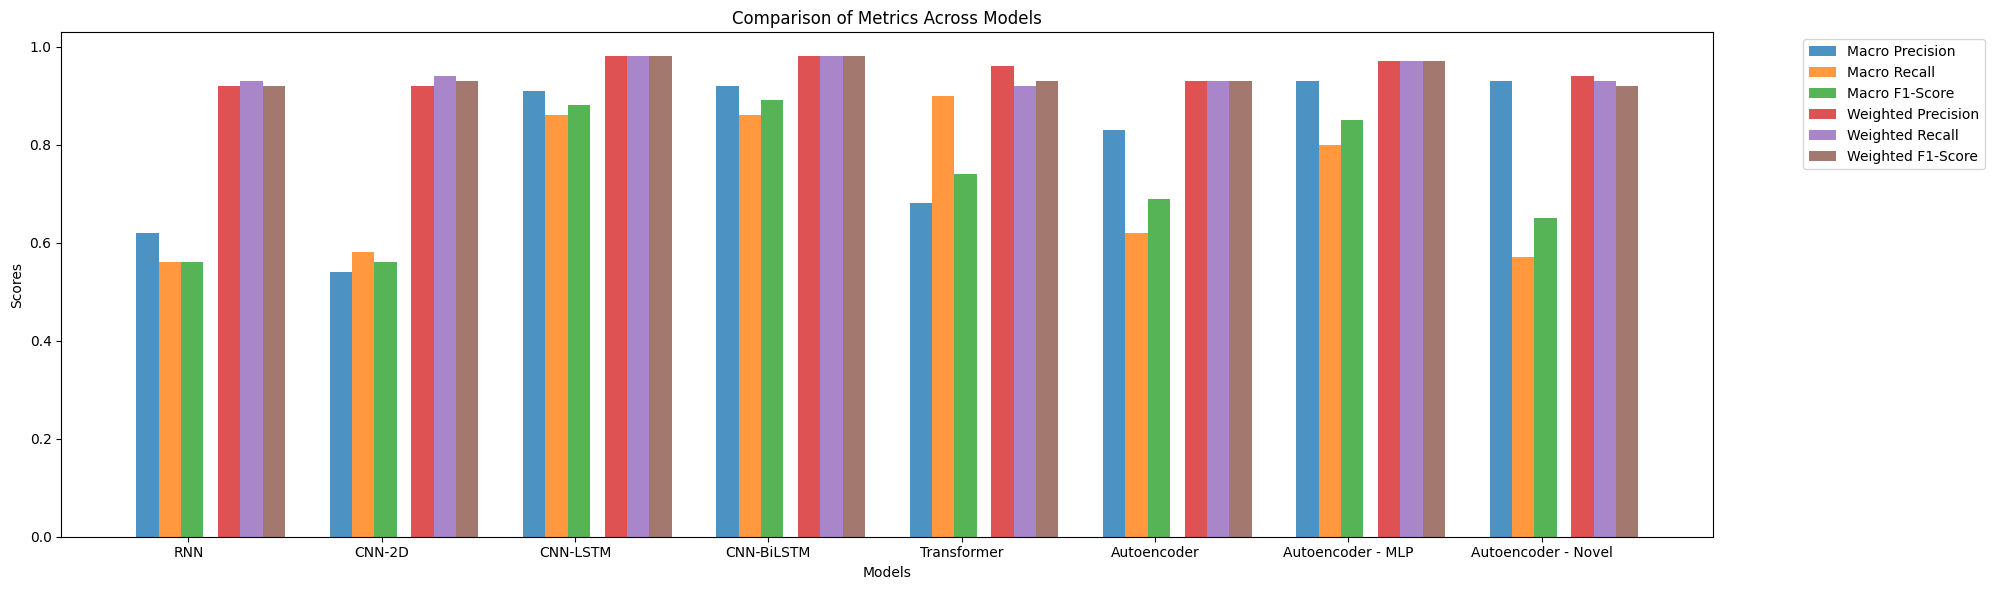

In [5]:
models = ['RNN', 'CNN-2D', 'CNN-LSTM', 'CNN-BiLSTM', 'Transformer', 'Autoencoder', 'Autoencoder - MLP', 'Autoencoder - Novel']
metrics = ['Precision', 'Recall', 'F1-Score']
macro_avg = [
    [0.62, 0.56, 0.56],
    [0.54, 0.58, 0.56],
    [0.91, 0.86, 0.88],
    [0.92, 0.86, 0.89],
    [0.68, 0.90, 0.74],
    [0.83, 0.62, 0.69],
    [0.93, 0.80, 0.85],
    [0.93, 0.57, 0.65]
]
weighted_avg = [
    [0.92, 0.93, 0.92],
    [0.92, 0.94, 0.93],
    [0.98, 0.98, 0.98],
    [0.98, 0.98, 0.98],
    [0.96, 0.92, 0.93],
    [0.93, 0.93, 0.93],
    [0.97, 0.97, 0.97],
    [0.94, 0.93, 0.92]
]

gap_between_models = 0.4
gap = 0.1
bar_width = 0.15
x_positions = np.arange(len(models)) * (bar_width * len(metrics) * 2 + gap_between_models)

fig, ax = plt.subplots(figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax.bar(x_positions + i * bar_width - (bar_width * len(metrics) / 2 + gap / 2),
           [m[i] for m in macro_avg], bar_width, label=f'Macro {metric}', alpha=0.8)

for i, metric in enumerate(metrics):
    ax.bar(x_positions + i * bar_width + (bar_width * len(metrics) / 2 + gap / 2),
           [w[i] for w in weighted_avg], bar_width, label=f'Weighted {metric}', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks(x_positions)
ax.set_xticklabels(models)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

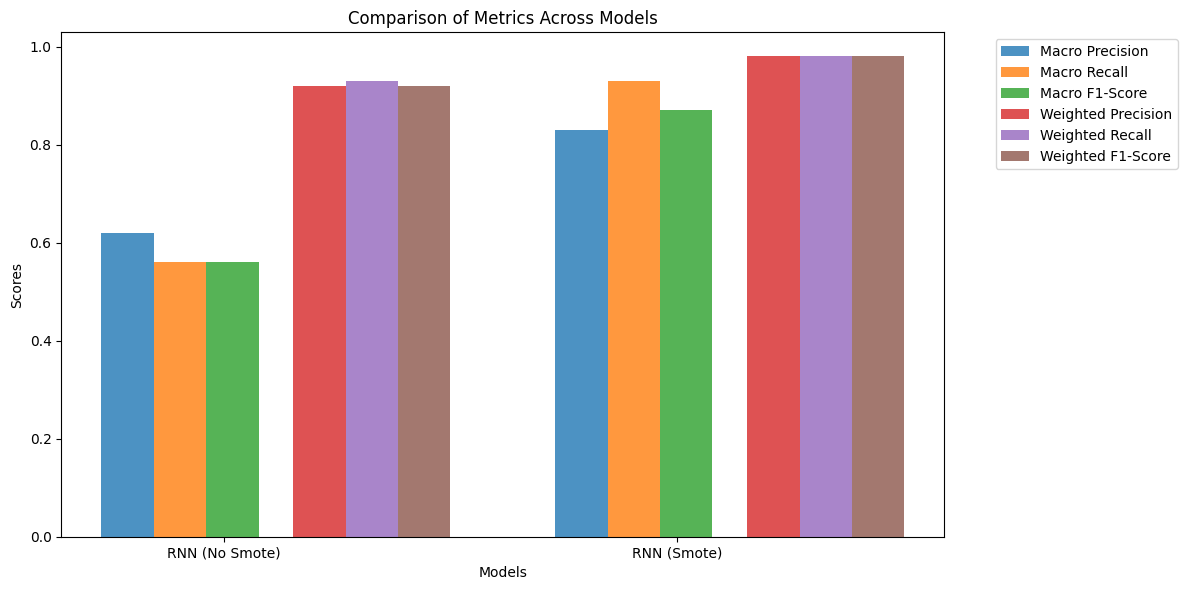

In [2]:
models = ['RNN (No Smote)', 'RNN (Smote)']
metrics = ['Precision', 'Recall', 'F1-Score']
macro_avg = [
    [0.62, 0.56, 0.56],
    [0.83, 0.93, 0.87],
]
weighted_avg = [
    [0.92, 0.93, 0.92],
    [0.98, 0.98, 0.98],
]

gap_between_models = 0.4
gap = 0.1
bar_width = 0.15
x_positions = np.arange(len(models)) * (bar_width * len(metrics) * 2 + gap_between_models)
fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    ax.bar(x_positions + i * bar_width - (bar_width * len(metrics) / 2 + gap / 2),
           [m[i] for m in macro_avg], bar_width, label=f'Macro {metric}', alpha=0.8)
for i, metric in enumerate(metrics):
    ax.bar(x_positions + i * bar_width + (bar_width * len(metrics) / 2 + gap / 2),
           [w[i] for w in weighted_avg], bar_width, label=f'Weighted {metric}', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks(x_positions)
ax.set_xticklabels(models)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Splitting Training & Validation Data

In [5]:
raw_train_df = pd.read_csv('mitbih_train.csv')
raw_test_df = pd.read_csv('mitbih_test.csv')
df_test = raw_test_df

df_train, df_val = train_test_split(raw_train_df, test_size=0.2, random_state=0)
df_test = raw_test_df
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(70042, 188)
(17511, 188)
(21891, 188)


In [11]:
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# COMMENT IF NOT USING TRANSFORMER MODEL
# x_train = x_train.unsqueeze(-1)  # Now shape: (num_samples, seq_length, 1)
# x_val = x_val.unsqueeze(-1)      # Now shape: (num_samples, seq_length, 1)
# x_test = x_test.unsqueeze(-1)      # Now shape: (num_samples, seq_length, 1)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

torch.Size([70042, 187])
torch.Size([17511, 187])
torch.Size([21891, 187])
torch.Size([70042])
torch.Size([17511])
torch.Size([21891])


## CNN Model code



In [7]:

class CNNModel_1d(nn.Module):
    def __init__(self, cnn_output_dim, num_classes):
        super(CNNModel_1d, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # MaxPooling with pool size 2
            nn.Conv1d(in_channels=32, out_channels=cnn_output_dim, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # MaxPooling with pool size 2
            nn.Flatten(),
            nn.Linear(64 * 45, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        cnn_output = self.cnn(x)
        return cnn_output


class CNNModel_2d(nn.Module):
    def __init__(self, cnn_output_dim, num_classes):
        super(CNNModel_2d, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling with pool size 2
            nn.Conv2d(in_channels=32, out_channels=cnn_output_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling with pool size 2
            nn.Flatten(),
            nn.Linear(64 * 8 * 47, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        cnn_output = self.cnn(x)
        return cnn_output


## Helper Functions for CNN Model

In [15]:
# Helper functions

def stft(signals, n_fft, hop_length, win_length, window,center, return_complex=True):
    signals = signals.to(device)
    spectrogram = torch.stft(signals, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center, return_complex=True)
    spectrogram = torch.abs(spectrogram)  # Shape: [batch_size, freq_bins, time_steps]
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
    # spectrogram = spectrogram.unsqueeze(1)
    return spectrogram

def train_loop_1d(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    # Move inputs and labels to the same device as the model (GPU or CPU)
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size
  return train_loss, train_correct

def train_loop_2d(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for X, y in tqdm(train_dataloader, desc="Training", leave=False):
    # Move inputs and labels to the same device as the model (GPU or CPU)
    X = X.to(device)
    X = stft(X, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center) # Conv2D
    y = y.to(device)

    # Compute prediction and loss
    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size
  return train_loss, train_correct

def test_loop_1d(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in test_dataloader:
      # Move inputs and labels to the same device as the model (GPU or CPU)
      X = X.to(device)
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size
  return test_loss, test_correct

def test_loop_2d(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in tqdm(test_dataloader, desc="Testing", leave=False):
      # Move inputs and labels to the same device as the model (GPU or CPU)
      X = X.to(device)
      X = stft(X, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center) # Conv2D
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size
  return test_loss, test_correct



class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train_1d(model, x_train, y_train, x_test, y_test, batch_size):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    early_stopper = EarlyStopper(patience=patience, min_delta=0)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to TensorDataset for DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Loaders for batching
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(no_epochs):
        train_loss, train_correct = train_loop_1d(train_loader, model, loss_fn, optimizer)
        test_loss, test_correct = test_loop_1d(test_loader, model, loss_fn)

        train_losses.append(train_loss)
        train_accuracies.append(train_correct)
        test_losses.append(test_loss)
        test_accuracies.append(test_correct)

        print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")

        if early_stopper.early_stop(test_loss):
            print('Done')
            break

    return train_accuracies, train_losses, test_accuracies, test_losses


def train_2d(model, x_train, y_train, x_test, y_test, batch_size):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    early_stopper = EarlyStopper(patience=patience, min_delta=0)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to TensorDataset for DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Loaders for batching
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(no_epochs):
        train_loss, train_correct = train_loop_2d(train_loader, model, loss_fn, optimizer)
        test_loss, test_correct = test_loop_2d(test_loader, model, loss_fn)

        train_losses.append(train_loss)
        train_accuracies.append(train_correct)
        test_losses.append(test_loss)
        test_accuracies.append(test_correct)

        print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")

        if early_stopper.early_stop(test_loss):
            print('Done')
            break

    return train_accuracies, train_losses, test_accuracies, test_losses

## CNN Models

In [ ]:
model = CNNModel_1d(cnn_output_dim=cnn_output_size, num_classes=num_classes)
model.to(device)

CNNModel_1d(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=5, bias=True)
    (10): ReLU()
  )
)

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses = train_1d(model, x_train, y_train, x_val, y_val, batch_size)

Epoch 1: Train_accuracy: 75.96%, Train_loss: 1.143525, Val_accuracy: 84.67%, Val_loss: 0.968284
Epoch 2: Train_accuracy: 86.31%, Train_loss: 0.937463, Val_accuracy: 91.29%, Val_loss: 0.871834
Epoch 3: Train_accuracy: 88.77%, Train_loss: 0.857957, Val_accuracy: 90.58%, Val_loss: 0.807021
Epoch 4: Train_accuracy: 90.00%, Train_loss: 0.821341, Val_accuracy: 90.74%, Val_loss: 0.786973
Epoch 5: Train_accuracy: 90.87%, Train_loss: 0.798484, Val_accuracy: 92.67%, Val_loss: 0.763970
Epoch 6: Train_accuracy: 91.62%, Train_loss: 0.769007, Val_accuracy: 89.37%, Val_loss: 0.763717
Epoch 7: Train_accuracy: 91.75%, Train_loss: 0.755916, Val_accuracy: 91.04%, Val_loss: 0.739473
Epoch 8: Train_accuracy: 92.06%, Train_loss: 0.737937, Val_accuracy: 93.34%, Val_loss: 0.732599
Epoch 9: Train_accuracy: 92.23%, Train_loss: 0.730814, Val_accuracy: 92.20%, Val_loss: 0.734482
Epoch 10: Train_accuracy: 92.50%, Train_loss: 0.719464, Val_accuracy: 90.93%, Val_loss: 0.720206
Epoch 11: Train_accuracy: 92.74%, Train

In [9]:
# model = CNN_RNN_Hybrid(input_size, cnn_output_size, hidden_size, num_classes)
# model = CNNModel(cnn_output_dim=cnn_output_size, num_classes=num_classes)
model2 = CNNModel_2d(cnn_output_dim=cnn_output_size, num_classes=num_classes)
model2.to(device)

CNNModel_2d(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=24064, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=5, bias=True)
    (10): ReLU()
  )
)

In [16]:
train_accuracies_2d, train_losses_2d, val_accuracies_2d, val_losses_2d = train_2d(model2, x_train, y_train, x_val, y_val, batch_size)

Epoch 1: Train_accuracy: 78.09%, Train_loss: 1.021342, Val_accuracy: 82.64%, Val_loss: 0.976330


Epoch 2: Train_accuracy: 79.14%, Train_loss: 0.991521, Val_accuracy: 77.73%, Val_loss: 0.951187


Epoch 3: Train_accuracy: 80.21%, Train_loss: 0.974768, Val_accuracy: 83.30%, Val_loss: 0.933952


Epoch 4: Train_accuracy: 80.78%, Train_loss: 0.961238, Val_accuracy: 78.93%, Val_loss: 0.918209


Epoch 5: Train_accuracy: 81.10%, Train_loss: 0.943175, Val_accuracy: 79.82%, Val_loss: 0.901498


Epoch 6: Train_accuracy: 81.69%, Train_loss: 0.931603, Val_accuracy: 83.39%, Val_loss: 0.901894


Epoch 7: Train_accuracy: 81.79%, Train_loss: 0.921785, Val_accuracy: 79.98%, Val_loss: 0.898070


Epoch 8: Train_accuracy: 82.23%, Train_loss: 0.917480, Val_accuracy: 80.78%, Val_loss: 0.909465


Epoch 9: Train_accuracy: 82.47%, Train_loss: 0.906105, Val_accuracy: 82.69%, Val_loss: 0.879755


Epoch 10: Train_accuracy: 82.51%, Train_loss: 0.903787, Val_accuracy: 79.42%, Val_loss: 0.882719


Epoch 11: Train_accuracy: 83.22%, Train_loss: 0.895323, Val_accuracy: 85.49%, Val_loss: 0.868231


Epoch 12: Train_accuracy: 83.39%, Train_loss: 0.885759, Val_accuracy: 81.30%, Val_loss: 0.869827


Epoch 13: Train_accuracy: 83.54%, Train_loss: 0.883072, Val_accuracy: 82.23%, Val_loss: 0.865413


Epoch 14: Train_accuracy: 83.72%, Train_loss: 0.873871, Val_accuracy: 83.11%, Val_loss: 0.858800


Epoch 15: Train_accuracy: 83.79%, Train_loss: 0.874574, Val_accuracy: 84.40%, Val_loss: 0.846834


Epoch 16: Train_accuracy: 84.33%, Train_loss: 0.871000, Val_accuracy: 85.23%, Val_loss: 0.849901


Epoch 17: Train_accuracy: 84.44%, Train_loss: 0.865882, Val_accuracy: 83.36%, Val_loss: 0.844167


Epoch 18: Train_accuracy: 84.61%, Train_loss: 0.862411, Val_accuracy: 85.62%, Val_loss: 0.845393


Epoch 19: Train_accuracy: 84.73%, Train_loss: 0.852275, Val_accuracy: 85.59%, Val_loss: 0.822262


Epoch 20: Train_accuracy: 85.02%, Train_loss: 0.852099, Val_accuracy: 86.16%, Val_loss: 0.848735


Epoch 21: Train_accuracy: 85.08%, Train_loss: 0.838703, Val_accuracy: 85.11%, Val_loss: 0.835170


Epoch 22: Train_accuracy: 85.30%, Train_loss: 0.838524, Val_accuracy: 85.75%, Val_loss: 0.829087
Done


## Helper Functions for Transformer Model


In [ ]:

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (seq_len, batch_size, d_model)
        Returns:
            Tensor with positional embeddings added
        """
        # print(x.shape)
        seq_len, batch_size, d_model = x.size()
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(1).expand(seq_len, batch_size)  # (seq_len, batch)
        pos_emb = self.pos_embedding(positions)  # (seq_len, batch, d_model)
        x = x + pos_emb
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, output_dim, max_len=1000, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = LearnedPositionalEncoding(model_dim, max_len, dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.classifier = nn.Linear(model_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, src):
        """
        Args:
            src: Tensor of shape (seq_length, batch_size, input_dim)
        Returns:
            out: Tensor of shape (batch_size, output_dim)
        """
        # print(src.shape)
        src = src.permute(1, 0, 2)  # (seq_length, batch_size, input_dim)

        embedded = self.input_embedding(src)  # (seq_len, batch, model_dim)
        embedded = self.positional_encoding(embedded)  # (seq_len, batch, model_dim)

        encoded = self.transformer_encoder(embedded)  # (seq_len, batch, model_dim)

        # Pooling: Use mean pooling
        pooled = encoded.mean(dim=0)  # (batch, model_dim)

        out = self.dropout(pooled)
        out = self.relu(out)
        out = self.classifier(out)  # (batch, output_dim)

        return out


def train_loop_transformer(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for X, y in tqdm(train_dataloader, desc="Training", leave=False):

    # Move inputs and labels to the same device as the model (GPU or CPU)
    # print(X.shape)
    # print(y.shape)
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size
  return train_loss, train_correct

def test_loop_transformer(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in tqdm(test_dataloader, desc="Testing", leave=False):
      # Move inputs and labels to the same device as the model (GPU or CPU)
      X = X.to(device)
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size
  return test_loss, test_correct

def train_transformer(model, x_train, y_train, x_test, y_test, batch_size):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  early_stopper = EarlyStopper(patience=patience, min_delta=0)
  loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Convert data to TensorDataset for DataLoader
  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)

  # Loaders for batching
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  for epoch in range(no_epochs):
    train_loss, train_correct = train_loop_transformer(train_loader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop_transformer(test_loader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_correct)
    test_losses.append(test_loss)
    test_accuracies.append(test_correct)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
      print('Done')
      break

  return train_accuracies, train_losses, test_accuracies, test_losses



In [ ]:

model_transformer = TransformerClassifier(input_dim=1, model_dim=256, num_heads=8, num_encoder_layers=4, output_dim=5, max_len=187, dropout=0.05)
model_transformer.to(device)


TransformerClassifier(
  (input_embedding): Linear(in_features=1, out_features=256, bias=True)
  (positional_encoding): LearnedPositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
    (pos_embedding): Embedding(187, 256)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=256, 

In [ ]:
print(x_train.shape, x_val.shape)

train_accuracies, train_losses, val_accuracies, val_losses = train_transformer(model_transformer, x_train, y_train, x_val, y_val, batch_size)

torch.Size([70042, 187, 1]) torch.Size([17511, 187, 1])
Epoch 1: Train_accuracy: 59.22%, Train_loss: 1.015946, Val_accuracy: 65.08%, Val_loss: 0.871403
Epoch 2: Train_accuracy: 78.72%, Train_loss: 0.619434, Val_accuracy: 88.16%, Val_loss: 0.570517
Epoch 3: Train_accuracy: 83.55%, Train_loss: 0.493447, Val_accuracy: 83.18%, Val_loss: 0.488377
Epoch 4: Train_accuracy: 85.40%, Train_loss: 0.427928, Val_accuracy: 91.31%, Val_loss: 0.393736
Epoch 5: Train_accuracy: 86.21%, Train_loss: 0.391974, Val_accuracy: 89.68%, Val_loss: 0.363080
Epoch 6: Train_accuracy: 87.48%, Train_loss: 0.344575, Val_accuracy: 83.27%, Val_loss: 0.377037
Epoch 7: Train_accuracy: 87.71%, Train_loss: 0.325079, Val_accuracy: 90.58%, Val_loss: 0.327349
Epoch 8: Train_accuracy: 88.49%, Train_loss: 0.305406, Val_accuracy: 86.61%, Val_loss: 0.323490
Epoch 9: Train_accuracy: 88.47%, Train_loss: 0.298247, Val_accuracy: 89.78%, Val_loss: 0.312926
Epoch 10: Train_accuracy: 88.76%, Train_loss: 0.280715, Val_accuracy: 83.44%, Va

In [ ]:
torch.save(model_transformer.state_dict(), 'transformerv2.pth')


## Model evaluation

We can observe that the accuracy on the test set is very good. However, as we found earlier, the dataset is imbalanced, which may mean that the accuracy could be misleading and not reflect actual performance of the predictions for all classes.

In [17]:
def get_predictions_1d(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions



def evaluate_model(model, x_test, y_test, device):
    loss_fn = nn.CrossEntropyLoss()

    # Convert data to TensorDataset for DataLoader
    test_dataset = TensorDataset(x_test, y_test)
    # Loaders for batching
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    # Get overall test loss and accuracy to evaluate results
    test_loss, test_accuracy = test_loop_1d(test_loader, model, loss_fn)
    print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

    # Get predictions for the test set
    predicted_labels_1d = get_predictions_1d(model, test_loader, device)
    # Get actual labels for the test set
    actual_labels_1d = y_test.tolist()
    # Get class labels
    class_labels = ["N", "S", "V", "F", "Q"]


    # Create confusion matrix to evaluate results
    cm = confusion_matrix(actual_labels_1d, predicted_labels_1d, labels=[0,1,2,3,4])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".5f")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    # Get classification report to evaluate results
    print(classification_report(actual_labels_1d, predicted_labels_1d, target_names=class_labels))


# ---------------



def get_predictions_2d(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)
      inputs = stft(inputs, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions


def evaluate_model_2d(model, x_test, y_test, device):
    loss_fn = nn.CrossEntropyLoss()

    # Convert data to TensorDataset for DataLoader
    test_dataset = TensorDataset(x_test, y_test)
    # Loaders for batching
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    # Get overall test loss and accuracy to evaluate results
    test_loss, test_accuracy = test_loop_2d(test_loader, model, loss_fn)
    print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

    # Get predictions for the test set
    predicted_labels_2d = get_predictions_2d(model, test_loader, device)
    # Get actual labels for the test set
    actual_labels_2d = y_test.tolist()
    # Get class labels
    class_labels = ["N", "S", "V", "F", "Q"]


    # Create confusion matrix to evaluate results
    cm = confusion_matrix(actual_labels_2d, predicted_labels_2d, labels=[0,1,2,3,4])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".5f")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    # Get classification report to evaluate results
    print(classification_report(actual_labels_2d, predicted_labels_2d, target_names=class_labels))


# ---------------



def get_predictions_transformer(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions


def evaluate_model_transformer(model, x_test, y_test, device):
    loss_fn = nn.CrossEntropyLoss()

    # Convert data to TensorDataset for DataLoader
    test_dataset = TensorDataset(x_test, y_test)
    # Loaders for batching
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    # Get overall test loss and accuracy to evaluate results
    test_loss, test_accuracy = test_loop_transformer(test_loader, model, loss_fn)
    print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

    # Get predictions for the test set
    predicted_labels_transformer = get_predictions_transformer(model, test_loader, device)
    # Get actual labels for the test set
    actual_labels_transformer = y_test.tolist()
    # Get class labels
    class_labels = ["N", "S", "V", "F", "Q"]


    # Create confusion matrix to evaluate results
    cm = confusion_matrix(actual_labels_transformer, predicted_labels_transformer, labels=[0,1,2,3,4])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".5f")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    # Get classification report to evaluate results
    print(classification_report(actual_labels_transformer, predicted_labels_transformer, target_names=class_labels))

Test accuracy: 92.14%, Test loss: 0.234010


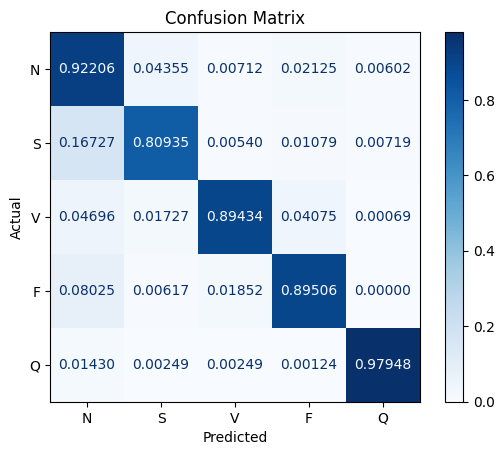

              precision    recall  f1-score   support

           N       0.99      0.92      0.95     18117
           S       0.35      0.81      0.49       556
           V       0.90      0.89      0.90      1448
           F       0.24      0.90      0.38       162
           Q       0.93      0.98      0.96      1608

    accuracy                           0.92     21891
   macro avg       0.68      0.90      0.74     21891
weighted avg       0.96      0.92      0.93     21891



In [ ]:
# For Transformer model v2 without SMOTE

evaluate_model_transformer(model_transformer, x_test, y_test, device)

Test accuracy: 94.45%, Test loss: 0.270769


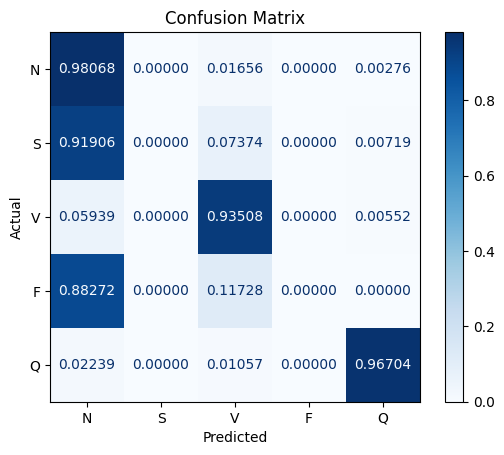

              precision    recall  f1-score   support

           N       0.96      0.98      0.97     18117
           S       0.00      0.00      0.00       556
           V       0.78      0.94      0.85      1448
           F       0.00      0.00      0.00       162
           Q       0.96      0.97      0.96      1608

    accuracy                           0.94     21891
   macro avg       0.54      0.58      0.56     21891
weighted avg       0.92      0.94      0.93     21891



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# For CNN_1d model
evaluate_model(model, x_test=x_test, y_test=y_test, device=device)

Test accuracy: 85.37%, Test loss: 0.435595


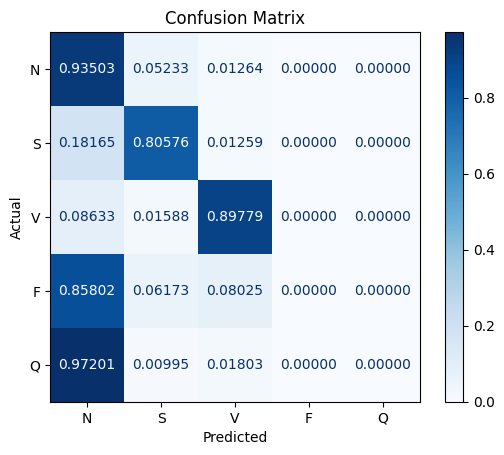

              precision    recall  f1-score   support

           N       0.90      0.94      0.92     18117
           S       0.31      0.81      0.45       556
           V       0.82      0.90      0.86      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.85     21891
   macro avg       0.41      0.53      0.44     21891
weighted avg       0.81      0.85      0.83     21891



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# For CNN_2d model
evaluate_model_2d(model2, x_test=x_test, y_test=y_test, device=device)

From the relative accuracies for the different classes, we can observe that the model does not perform that well in predicting samples in class 1, 2 and 3 relative to class 0 and 4 as can be observed by the f1-score.

We can explore ways to augment the original datasets to tackle this.

## Data Transformation

### SMOTE

In [ ]:
raw_train_df = pd.read_csv('mitbih_train.csv')
raw_test_df = pd.read_csv('mitbih_test.csv')
df_train, df_val = train_test_split(raw_train_df, test_size=0.2, random_state=0)
df_test = raw_test_df


smote_over_sampler = SMOTE()
x_resampled, y_resampled = smote_over_sampler.fit_resample(df_train.iloc[:, :-1], df_train.iloc[:, -1])

resampled_train_df = pd.concat([pd.DataFrame(x_resampled), pd.DataFrame(y_resampled)], axis=1)

df_train_resampled, df_val_resampled = train_test_split(resampled_train_df, test_size=0.2, random_state=0)

x_train_resampled = df_train_resampled.iloc[:, :-1]
y_train_resampled = df_train_resampled.iloc[:, -1]

x_val_resampled = df_val_resampled.iloc[:, :-1]
y_val_resampled = df_val_resampled.iloc[:, -1]

x_train_resampled = torch.tensor(x_train_resampled.values, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled.values, dtype=torch.long)

x_val_resampled = torch.tensor(x_val_resampled.values, dtype=torch.float32)
y_val_resampled = torch.tensor(y_val_resampled.values, dtype=torch.long)


# COMMENT IF NOT USING TRANSFORMER MODEL
x_train_resampled = x_train_resampled.unsqueeze(-1)  # Now shape: (num_samples, seq_length, 1)
x_val_resampled = x_val_resampled.unsqueeze(-1)      # Now shape: (num_samples, seq_length, 1)

print(x_train_resampled.shape)
print(x_val_resampled.shape)

torch.Size([231864, 187, 1])
torch.Size([57966, 187, 1])


In [ ]:
# Observe new count for classes
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 46290]
 [    1 46362]
 [    2 46415]
 [    3 46328]
 [    4 46469]]


In [ ]:
smote_model = TransformerClassifier(input_dim=1, model_dim=256, num_heads=8, num_encoder_layers=4, output_dim=5, max_len=187, dropout=0.05)
smote_model.load_state_dict(torch.load('transformerv3.pth'))
smote_model.to(device)

<ipython-input-38-80eb2822df80>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smote_model.load_state_dict(torch.load('transformerv2.pth'))


TransformerClassifier(
  (input_embedding): Linear(in_features=1, out_features=256, bias=True)
  (positional_encoding): LearnedPositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
    (pos_embedding): Embedding(187, 256)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=256, 

# help me run


In [30]:
# To Run


import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm


# Set seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

raw_train_df = pd.read_csv('mitbih_train.csv')
raw_test_df = pd.read_csv('mitbih_test.csv')
df_train, df_val = train_test_split(raw_train_df, test_size=0.2, random_state=0)
df_test = raw_test_df

input_size = 187
cnn_output_size = 64
hidden_size = 128
num_classes = 5

patience = 3
no_epochs = 50
batch_size = 128
lr = 0.0001

y_train = df_train.iloc[:, -1]
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

smote_over_sampler = SMOTE()
x_resampled, y_resampled = smote_over_sampler.fit_resample(df_train.iloc[:, :-1], df_train.iloc[:, -1])

resampled_train_df = pd.concat([pd.DataFrame(x_resampled), pd.DataFrame(y_resampled)], axis=1)

df_train_resampled, df_val_resampled = train_test_split(resampled_train_df, test_size=0.2, random_state=0)

x_train_resampled = df_train_resampled.iloc[:, :-1]
y_train_resampled = df_train_resampled.iloc[:, -1]

x_val_resampled = df_val_resampled.iloc[:, :-1]
y_val_resampled = df_val_resampled.iloc[:, -1]

x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

x_train_resampled = torch.tensor(x_train_resampled.values, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled.values, dtype=torch.long)

x_val_resampled = torch.tensor(x_val_resampled.values, dtype=torch.float32)
y_val_resampled = torch.tensor(y_val_resampled.values, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# COMMENT IF NOT USING TRANSFORMER MODEL
x_train_resampled = x_train_resampled.unsqueeze(-1)  # Now shape: (num_samples, seq_length, 1)
x_val_resampled = x_val_resampled.unsqueeze(-1)      # Now shape: (num_samples, seq_length, 1)
x_test = x_test.unsqueeze(-1)      # Now shape: (num_samples, seq_length, 1)

print(x_train_resampled.shape)
print(x_val_resampled.shape)


class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (seq_len, batch_size, d_model)
        Returns:
            Tensor with positional embeddings added
        """
        # print(x.shape)
        seq_len, batch_size, d_model = x.size()
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(1).expand(seq_len, batch_size)  # (seq_len, batch)
        pos_emb = self.pos_embedding(positions)  # (seq_len, batch, d_model)
        x = x + pos_emb
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, output_dim, max_len=1000, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = LearnedPositionalEncoding(model_dim, max_len, dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.classifier = nn.Linear(model_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, src):
        """
        Args:
            src: Tensor of shape (seq_length, batch_size, input_dim)
        Returns:
            out: Tensor of shape (batch_size, output_dim)
        """
        # print(src.shape)
        src = src.permute(1, 0, 2)  # (seq_length, batch_size, input_dim)

        embedded = self.input_embedding(src)  # (seq_len, batch, model_dim)
        embedded = self.positional_encoding(embedded)  # (seq_len, batch, model_dim)

        encoded = self.transformer_encoder(embedded)  # (seq_len, batch, model_dim)

        # Pooling: Use mean pooling
        pooled = encoded.mean(dim=0)  # (batch, model_dim)

        out = self.dropout(pooled)
        out = self.relu(out)
        out = self.classifier(out)  # (batch, output_dim)

        return out


def train_loop_transformer(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for X, y in tqdm(train_dataloader, desc="Training", leave=False):

    # Move inputs and labels to the same device as the model (GPU or CPU)
    # print(X.shape)
    # print(y.shape)
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size
  return train_loss, train_correct

def test_loop_transformer(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in tqdm(test_dataloader, desc="Testing", leave=False):
      # Move inputs and labels to the same device as the model (GPU or CPU)
      X = X.to(device)
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size
  return test_loss, test_correct

def train_transformer(model, x_train, y_train, x_test, y_test, batch_size):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  early_stopper = EarlyStopper(patience=patience, min_delta=0)
  loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Convert data to TensorDataset for DataLoader
  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)

  # Loaders for batching
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  model.train()
  for epoch in range(no_epochs):
    train_loss, train_correct = train_loop_transformer(train_loader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop_transformer(test_loader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_correct)
    test_losses.append(test_loss)
    test_accuracies.append(test_correct)

    torch.save(model.state_dict(), 'transformerv3.pth')
    print(f"Model saved, Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")


    if early_stopper.early_stop(test_loss):
      print('Done')
      break

  return train_accuracies, train_losses, test_accuracies, test_losses


def get_predictions_transformer(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions


def evaluate_model_transformer(model, x_test, y_test, device):
    loss_fn = nn.CrossEntropyLoss()

    # Convert data to TensorDataset for DataLoader
    test_dataset = TensorDataset(x_test, y_test)
    # Loaders for batching
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    # Get overall test loss and accuracy to evaluate results
    test_loss, test_accuracy = test_loop_transformer(test_loader, model, loss_fn)
    print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

    # Get predictions for the test set
    predicted_labels_transformer = get_predictions_transformer(model, test_loader, device)
    # Get actual labels for the test set
    actual_labels_transformer = y_test.tolist()
    # Get class labels
    class_labels = ["N", "S", "V", "F", "Q"]


    # Create confusion matrix to evaluate results
    cm = confusion_matrix(actual_labels_transformer, predicted_labels_transformer, labels=[0,1,2,3,4])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".5f")
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


    # Get classification report to evaluate results
    print(classification_report(actual_labels_transformer, predicted_labels_transformer, target_names=class_labels))


cuda
torch.Size([231864, 187, 1])
torch.Size([57966, 187, 1])


In [31]:
smote_model = TransformerClassifier(input_dim=1, model_dim=256, num_heads=8, num_encoder_layers=4, output_dim=5, max_len=187, dropout=0.05)
smote_model.load_state_dict(torch.load('transformerv3.pth'))
smote_model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-31-e3611787c59d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

TransformerClassifier(
  (input_embedding): Linear(in_features=1, out_features=256, bias=True)
  (positional_encoding): LearnedPositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
    (pos_embedding): Embedding(187, 256)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=256, 

In [32]:
print(batch_size)
print(x_train_resampled.shape, x_val_resampled.shape)

train_accuracies, train_losses, val_accuracies, val_losses = train_transformer(smote_model, x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, batch_size)

128
torch.Size([231864, 187, 1]) torch.Size([57966, 187, 1])


Model saved, Epoch 1: Train_accuracy: 98.52%, Train_loss: 0.007965, Val_accuracy: 96.88%, Val_loss: 0.012855


KeyboardInterrupt: 

Test accuracy: 97.37%, Test loss: 0.128437


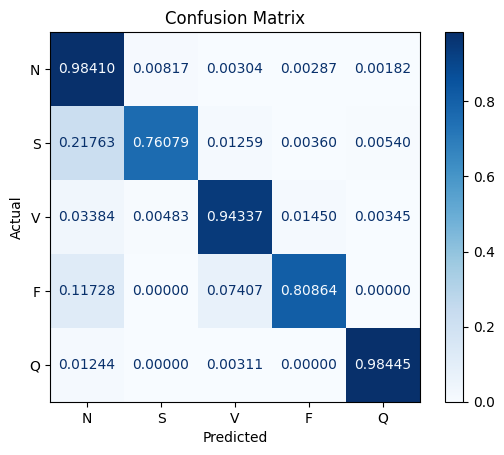

              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18117
           S       0.73      0.76      0.75       556
           V       0.95      0.94      0.94      1448
           F       0.64      0.81      0.71       162
           Q       0.97      0.98      0.98      1608

    accuracy                           0.97     21891
   macro avg       0.86      0.90      0.87     21891
weighted avg       0.98      0.97      0.97     21891



In [ ]:
evaluate_model_transformer(smote_model, x_test, y_test, device)

In [ ]:
#  torch.save(smote_model.state_dict(), 'transformerv3.pth')